In [103]:
# ==============================================================================
# 0. CONFIGURATION AND IMPORTS
# ==============================================================================

# 0.1 Utility Libraries (NumPy, Pandas)
import pandas as pd
import numpy as np

# 0.2 Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# 0.3 Statistical and Time Series Libraries
import scipy.stats as stats
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller

# Exploratory Data Analytics
---
### Loading the dataset
We start by loading the dataset from the CSV file using pandas.
This file contains the historical daily prices of the S&P 500 index.

In [104]:
df = pd.read_csv("../data/SPX.csv")

---

### Missing values & Duplicated rows


In [105]:
print("Missing values per column:\n", df.isnull().sum())

print("Number of duplicated rows:", df.duplicated().sum())

Missing values per column:
 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Number of duplicated rows: 0


The dataset contains **no missing values** or duplicated rows, which means the data is complete and consistent.
We can proceed without applying any cleaning operations for these aspects.

---

### Basic DataFrame information & descriptive statistics 

In [106]:
print(df.info())

print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23323 entries, 0 to 23322
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       23323 non-null  object 
 1   Open       23323 non-null  float64
 2   High       23323 non-null  float64
 3   Low        23323 non-null  float64
 4   Close      23323 non-null  float64
 5   Adj Close  23323 non-null  float64
 6   Volume     23323 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 1.2+ MB
None
               Open          High           Low         Close     Adj Close  \
count  23323.000000  23323.000000  23323.000000  23323.000000  23323.000000   
mean     486.821737    489.690119    483.762812    486.918598    486.918598   
std      726.187716    730.112168    721.890344    726.278798    726.278798   
min        4.400000      4.400000      4.400000      4.400000      4.400000   
25%       23.855001     23.855001     23.855001     23.855001     23.8

The dataset contains **23,323 rows** with no missing values. The `Date` column is still stored as an object and will need to be converted to datetime for proper time-series analysis. The descriptive statistics show a wide range in price levels and high variability, reflecting the long historical span of the data. Volume also displays large dispersion, with zeros in the earliest years when reliable volume data was not available.

---

### Converting `Date` to datetime and verifying ascending order

In [107]:
df["Date"] = pd.to_datetime(df["Date"])
df["Date"].is_monotonic_increasing

True

### Stablishing `Date` as index

In [108]:
df = df.set_index("Date")
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0
1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0
1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0
1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0
1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0


---

### Visualizing the historical S&P 500 price

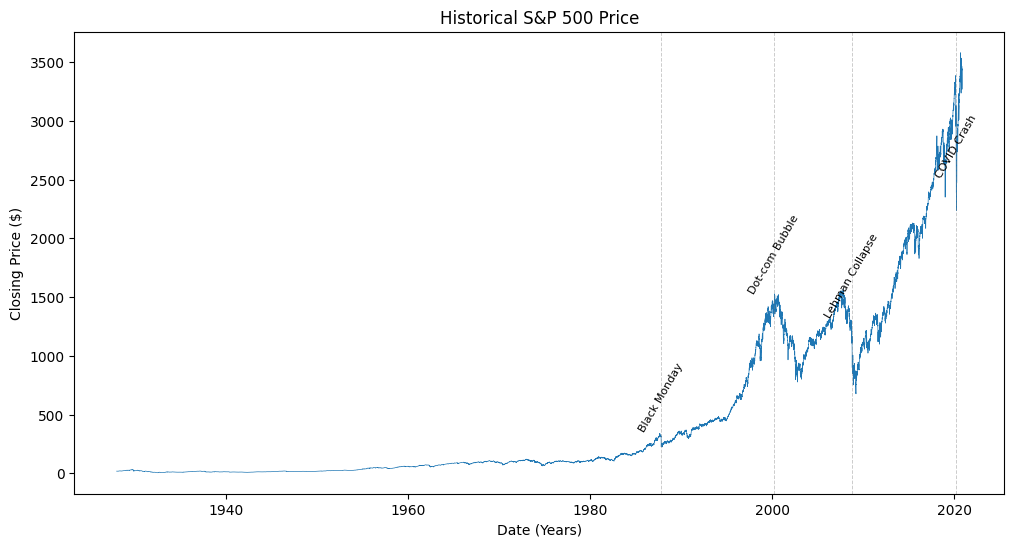

In [109]:
COLORS = {
    "price": "#1f77b4",
    "volume": "#7f7f7f",
    "returns": "#2ca02c",
    "volatility": "#d62728"
}

crisis_dates = [
    ("1987-10-19", "Black Monday"),
    ("2000-03-10", "Dot-com Bubble"),
    ("2008-09-15", "Lehman Collapse"),
    ("2020-03-16", "COVID Crash"),
]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df.index, df["Close"], color=COLORS["price"], linewidth = 0.5)

for date_str, label in crisis_dates:

    date = pd.to_datetime(date_str)

    ax.axvline(date, linestyle="--", color="gray", linewidth=0.7, alpha=0.4)

    y_pos = df["Close"].loc[date]

    ax.annotate(
        label,
        xy=(date, y_pos),
        xytext=(0, 10),
        textcoords="offset points",
        rotation=60,
        va="bottom",
        ha="center",
        fontsize=8,
        color="black"
    )

ax.set_title("Historical S&P 500 Price")
ax.set_xlabel("Date (Years)")
ax.set_ylabel("Closing Price ($)")
plt.show()

The S&P 500 displays a persistent long-term growth trend despite several major downturns. The annotated crisis dates mark periods of significant market stress, such as the dot-com bubble, the 2008 financial crisis and the COVID-19 shock.

---

### Exploring trading volume over time


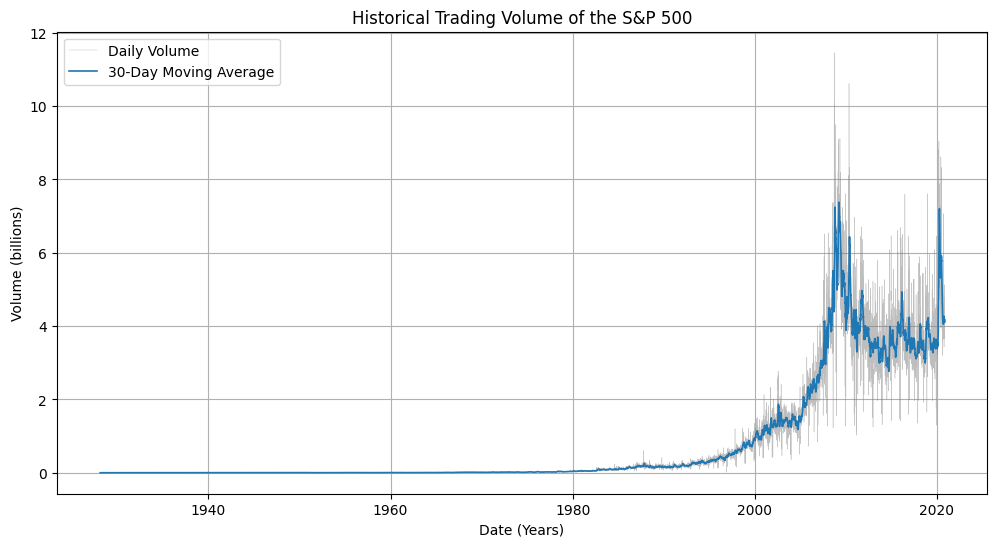

In [110]:
df["Volume_MA30"] = df["Volume"].rolling(window=30).mean()

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    df.index,
    df["Volume"] / 1e9,
    color=COLORS["volume"],
    linewidth=0.3,
    alpha=0.5,
    label="Daily Volume"
)

ax.plot(
    df.index,
    df["Volume_MA30"] / 1e9,
    color=COLORS["price"],
    linewidth=1.2,
    label="30-Day Moving Average"
)

ax.set_title("Historical Trading Volume of the S&P 500")
ax.set_xlabel("Date (Years)")
ax.set_ylabel("Volume (billions)")
ax.legend()
ax.grid()

plt.show()

The 30-day moving average smooths out short-term noise in daily trading volume, highlighting long-term structural trends and major spikes associated with market stress.

---

### DATA FILTERING & FEATURE ENGINEERING



In [ ]:
# Data Cleansing: Filtering the DataFrame to ensure reliable Volume data
first_valid_volume_date = df[df["Volume"] > 0].index[0]
df_model = df.loc[first_valid_volume_date:].copy()

# Feature Engineering: Calculating Log Returns and Rolling Volatility
df_model["Log_Return"] = np.log(df_model["Close"]/df_model["Close"].shift(1))

df_model["Volatility"] = df_model["Log_Return"].rolling(window=21).std()*np.sqrt(252) * 100

df_model["Momentum_126d"] = (df_model["Close"] - df_model["Close"].shift(126))/df_model["Close"].shift(126)
df_model.dropna(inplace=True)


---

### Detecting Non-Normality

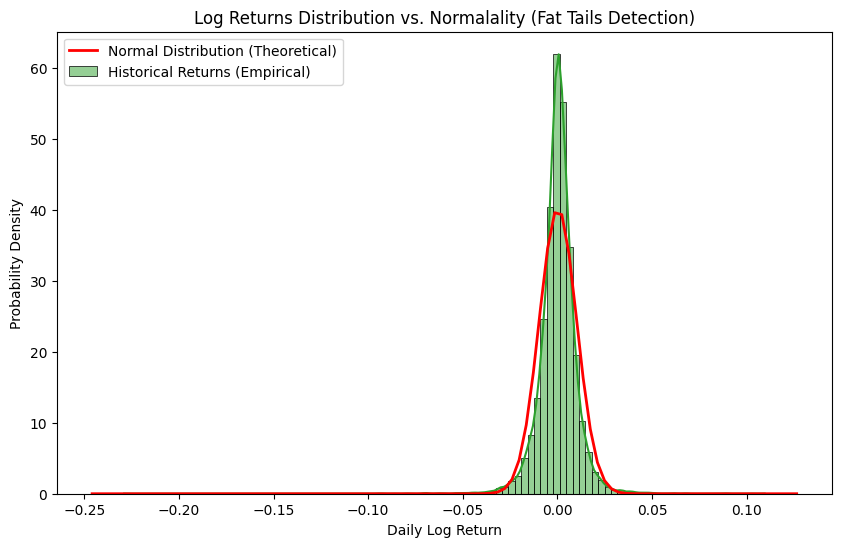

In [112]:
# 1. Calculate Parameters
mean_log_ret = df_model['Log_Return'].mean()
std_log_ret = df_model['Log_Return'].std()

fig, ax = plt.subplots(figsize = (10, 6))

# 2. Draw Histogram (Empirical Data)
sns.histplot(
    data = df_model,
    x = 'Log_Return',
    ax = ax, 
    stat = 'density',
    bins = 100,
    kde = True,
    color = COLORS['returns'],
    label = 'Historical Returns (Empirical)'
)

# 3. Calculate and Plot Theoretical Curve
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)

p = stats.norm.pdf(x, mean_log_ret, std_log_ret)

# Plot the line with corrected label
ax.plot(x, p, 'r', linewidth = 2, label = 'Normal Distribution (Theoretical)')

# 4. Finalize with Professional Labels
ax.set_title('Log Returns Distribution vs. Normalality (Fat Tails Detection)')
ax.set_xlabel('Daily Log Return')
ax.set_ylabel('Probability Density')
ax.legend()
plt.show()

The comparison between the **Empirical Returns** and the **Theoretical Normal Distribution** confirms two critical phenomena in financial markets:

1.  **Leptokurtosis (High Peak):** The center of the distribution is taller than the theoretical bell curve. This indicates that **small, insignificant daily movements are more frequent** than the normal model predicts.
2.  **Fat Tails (Higher Risk):** More data points are observed in the extreme tails (both positive and negative) compared to the red line. This is the definition of **Non-Normality** and justifies the use of advanced models, as it proves that **extreme, high-risk events occur more often** than simple statistical theory suggests.

---

### Visual Confirmation of Fat Tails: Quantile-Quantile (Q-Q) Plot

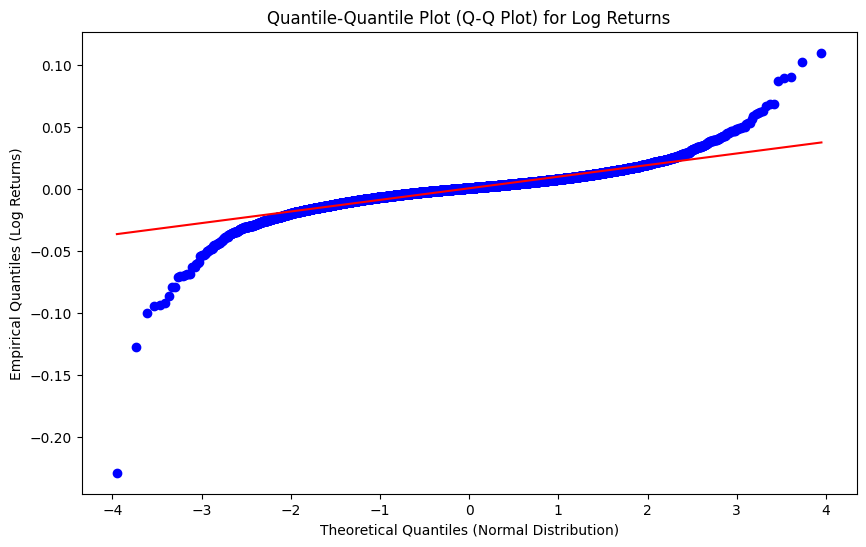

In [113]:
fig, ax = plt.subplots(figsize = (10, 6))

# Genera el Q-Q Plot
stats.probplot(x = df_model['Log_Return'], dist = 'norm', plot = ax)

# Añade el título para el portafolio
ax.set_title('Quantile-Quantile Plot (Q-Q Plot) for Log Returns')
ax.set_xlabel('Theoretical Quantiles (Normal Distribution)')
ax.set_ylabel('Empirical Quantiles (Log Returns)')

plt.show()

The Quantile-Quantile (Q-Q) Plot provides the definitive visual confirmation of the market's **Non-Normality** (Fat Tails).

1.  **Central Alignment:** The data points near the center of the plot (the body of the distribution) align closely with the diagonal line, indicating that small, routine daily movements are generally predictable.
2.  **Tails Deviation:** The most crucial observation is the severe curvature and deviation of the data points at both the **top-right** and **bottom-left** extremes (the tails). This signifies that the **Empirical Quantiles** (our real-world returns) are much larger than the **Theoretical Quantiles** (what a normal distribution predicts).

**This finding is the core justification for our project:** Simple statistical models that assume normal returns will severely **underestimate the probability of extreme, high-volatility events** (market crashes and surges).


---

### Final Validation: Stationarity Test and Momentum Feature

In [114]:
# ==============================================================================
# UTILITY FUNCTION FOR STATIONARITY TEST
# ==============================================================================

def run_adf_test(series, name=''):
    """
    Executes the Augmented Dickey-Fuller (ADF) test and prints the results.
    Used to mathematically confirm stationarity (or lack thereof).
    """
    # Ensure no NaN values are passed to the test
    series_clean = series.dropna()

    print(f"ADF Test for: {name}")
    
    # Execute the test
    result = adfuller(series_clean)
    
    adf_statistic = result[0]
    p_value = result[1]
    
    print(f'ADF Statistic: {adf_statistic:.2f}')
    print(f'p-value: {p_value:.2f}')
    
    # If p-value <= 0.05, we reject the null hypothesis (series is stationary)
    if p_value <= 0.05:
        print(f"✅ Conclusion: The p-value ({p_value:.2f}) is less than 0.05. The series is STATIONARY.")
    else:
        print(f"❌ Conclusion: The p-value ({p_value:.2f}) is greater than 0.05. The series is NOT STATIONARY.")
    print("-" * 40)

In [115]:
# --- EXECUTION ---

run_adf_test(df_model['Close'], 'Closing Price')

run_adf_test(df_model['Log_Return'], 'Log Returns')

ADF Test for: Closing Price
ADF Statistic: 3.22
p-value: 1.00
❌ Conclusion: The p-value (1.00) is greater than 0.05. The series is NOT STATIONARY.
----------------------------------------
ADF Test for: Log Returns
ADF Statistic: -23.16
p-value: 0.00
✅ Conclusion: The p-value (0.00) is less than 0.05. The series is STATIONARY.
----------------------------------------



The ADF test results definitively validate the data transformation strategy:

* The raw **Closing Price** is **Non-Stationary** (P-value = 1.00), meaning its mean and variance change over time. This makes it unsuitable for time-series modeling.
* The **Log Returns** are **Stationary** (P-value ≈ 0.00). This confirms that the Log Returns series is robust, stable, and ready to be used as a primary feature for the Hidden Markov Model.